In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from zipfile import ZipFile
filename="/content/drive/My Drive/HAM10000.zip"
# with ZipFile(filename,'r') as zip:
#   zip.extractall()
#   print("done")
!unzip "/content/drive/My Drive/HAM10000.zip" -d '/content/HAM10000'

Streaming output truncated to the last 5000 lines.
  inflating: /content/HAM10000/ISIC_0029321.jpg  
  inflating: /content/HAM10000/ISIC_0029322.jpg  
  inflating: /content/HAM10000/ISIC_0029323.jpg  
  inflating: /content/HAM10000/ISIC_0029324.jpg  
  inflating: /content/HAM10000/ISIC_0029325.jpg  
  inflating: /content/HAM10000/ISIC_0029326.jpg  
  inflating: /content/HAM10000/ISIC_0029327.jpg  
  inflating: /content/HAM10000/ISIC_0029328.jpg  
  inflating: /content/HAM10000/ISIC_0029329.jpg  
  inflating: /content/HAM10000/ISIC_0029330.jpg  
  inflating: /content/HAM10000/ISIC_0029331.jpg  
  inflating: /content/HAM10000/ISIC_0029332.jpg  
  inflating: /content/HAM10000/ISIC_0029333.jpg  
  inflating: /content/HAM10000/ISIC_0029334.jpg  
  inflating: /content/HAM10000/ISIC_0029335.jpg  
  inflating: /content/HAM10000/ISIC_0029336.jpg  
  inflating: /content/HAM10000/ISIC_0029337.jpg  
  inflating: /content/HAM10000/ISIC_0029338.jpg  
  inflating: /content/HAM10000/ISIC_0029339.jpg  

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
# os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
# a = tf.zeros([], tf.float32)

In [3]:
data = pd.read_csv('data/HAM10000_metadata')
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
unwanted_label = ['vasc','df']
data_pd = data.query("dx!=@unwanted_label")
print(data_pd['dx'].unique().tolist())

['bkl', 'nv', 'mel', 'bcc', 'akiec']


In [5]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [8]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [9]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

d:\pythonproject\hamclassification\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [10]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [11]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [12]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

d:\pythonproject\hamclassification\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [13]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
615,HAM_0005952,ISIC_0027916,bkl,histo,80.0,male,back,rosendahl,no
4636,HAM_0007389,ISIC_0029090,nv,follow_up,45.0,male,trunk,vidir_molemax,no
4276,HAM_0004894,ISIC_0030643,nv,follow_up,50.0,male,trunk,vidir_molemax,no
6033,HAM_0004610,ISIC_0025042,nv,follow_up,45.0,male,trunk,vidir_molemax,no
752,HAM_0004463,ISIC_0027770,bkl,histo,75.0,male,face,rosendahl,no


In [14]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [15]:
len(test_list)

812

In [16]:
len(train_list)

8946

In [17]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [41]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [42]:
targetnames = ['akiec', 'bcc', 'bkl', 'mel', 'nv']

In [43]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [44]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [45]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [46]:
targetnames = ['akiec', 'bcc', 'bkl', 'mel', 'nv']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.


In [18]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [19]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [20]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 38726 images belonging to 5 classes.

Test Batches: 
Found 812 images belonging to 5 classes.


In [21]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

output = resnet.output
output = Dense(5, activation='softmax', name='SoftMax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [ ]:

# output = GlobalAveragePooling2D()(conv)
# output = Dense(7, activation='softmax')(output)
# model = Model(inputs=resnet.input, outputs=output)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [24]:
class_weights = {   
                    0: 1.0,  # bkl
                    1: 1.0,  # nv
                    2: 5.0,  # mel
                    3: 1.0,  # bcc
                    4: 1.0,  # akiec
                }
                #['bkl', 'nv', 'mel', 'bcc', 'akiec']


checkpoint=  ModelCheckpoint(filepath = 'ResNet152.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=40, min_delta=0.001)

In [24]:
# from numba import cuda
# device = cuda.get_current_device()
# print(device)
# device.reset()

<CUDA device 0 'b'GeForce GTX 1650 Ti''>


In [ ]:
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=300,
                    verbose=1,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
894/894 [==============================] - 275s 296ms/step - loss: 2.3214 - accuracy: 0.2110 - val_loss: 1.2410 - val_accuracy: 0.0813

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras import models
model.load_weights("ResNet152.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'mel', 'nv']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.74      0.74        23
         bcc       0.91      0.77      0.83        26
         bkl       0.67      0.50      0.57        66
          df       0.80      0.67      0.73         6
         mel       0.52      0.50      0.51        34
          nv       0.95      0.98      0.96       663
        vasc       0.90      0.90      0.90        10

    accuracy                           0.90       828
   macro avg       0.78      0.72      0.75       828
weighted avg       0.90      0.90      0.90       828



In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8981171733390011
Recall: 0.9045893719806763
Accuracy: 0.9045893719806763
weighted Roc score: 0.9727752250647581


In [ ]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7832723409602609
Recall: 0.7219873902738353
Accuracy: 0.9045893719806763
Macro Roc score: 0.9758549231296252


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9045893719806763
Recall: 0.9045893719806763
Accuracy: 0.9045893719806763
Micro Roc score: 0.9931541333131073


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9808263570078315
The ROC AUC score of bcc is: 0.9974582773834644
The ROC AUC score of bkl is: 0.94887854927225
The ROC AUC score of df is: 0.97323600973236
The ROC AUC score of mel is: 0.9610683064157653
The ROC AUC score of nv is: 0.9741624388683212
The ROC AUC score of vasc is: 0.9953545232273838


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

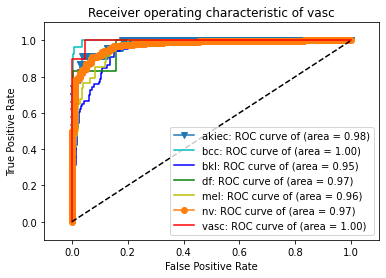

In [ ]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()